In [1]:
import pandas as pd
abbb = pd.read_csv('/content/abbb.csv',index_col=0)
abbb22 = pd.read_csv('/content/abbb22.csv',index_col=0)

In [2]:
# 必要なモジュールのインストール
!pip install xgboost

import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# 予測ターゲットと特徴量の格納
target_df = abbb[["volatility"]]
train_df = abbb.iloc[:, 2:20]

target_df22 = abbb22[["volatility"]]
train_df22 = abbb22.iloc[:, 2:20]

# トレーニングセットと検証セットに分割
X_train, X_valid, y_train, y_valid = train_test_split(train_df, target_df, test_size=0.2, random_state=42, shuffle=True)

X_test = train_df22
y_test = target_df22

# XGBoostで学習するためのデータ形式に変換
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X_test, label=y_test)

# モデルパラメータの設定
params = {
    'booster': 'gbtree',  # 木構造モデルを指定
    'objective': 'reg:squarederror',  # 回帰問題
    'eval_metric': 'rmse'
}

# モデルの学習
evals = [(dvalid, 'eval')]
model = xgb.train(params, dtrain, evals=evals)


[0]	eval-rmse:3.13557
[1]	eval-rmse:2.67484
[2]	eval-rmse:2.39521
[3]	eval-rmse:2.25244
[4]	eval-rmse:2.17347
[5]	eval-rmse:2.11762
[6]	eval-rmse:2.08670
[7]	eval-rmse:2.07507
[8]	eval-rmse:2.06611
[9]	eval-rmse:2.05128


In [5]:

#学習の保存
import pickle
with open('/content/model.pkl', 'wb') as model_file:
	pickle.dump(model, model_file)
pred = model.predict(dtest)


In [6]:
import numpy as np

In [7]:
# 性能向上に寄与する度合いで重要度をプロット
#lgb.plot_importance(model, height = 0.5, figsize = (8,16))

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import median_absolute_error


mae = mean_absolute_error(y_test, pred)
print("MAE:", round(mae, 4))

mse = mean_squared_error(y_test, pred)
print("MSE:", round(mse, 4))

rmse1 = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE 1:", round(rmse1, 4))

rmse2 = mean_squared_error(y_test, pred, squared=False)
print("RMSE 2:", round(rmse2, 4))

r2score = r2_score(y_test, pred)
print("R2 score:", round(r2score, 4))

MAE: 2.8409
MSE: 12.1928
RMSE 1: 3.4918
RMSE 2: 3.4918
R2 score: -2.0304


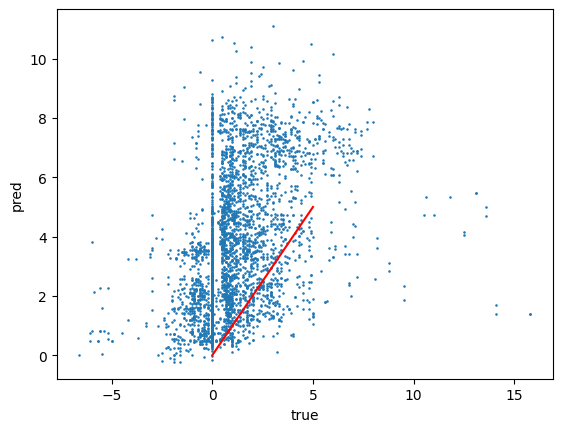

In [8]:
plt.scatter(y_test, pred,s=0.7,alpha = 1)
plt.plot(np.linspace(0, 5, 10), np.linspace(0, 5, 10), "red")
plt.xlabel('true')
plt.ylabel('pred')
plt.show()

In [9]:
fYfX = abbb22.iloc[::2,0:2].reset_index(drop=True)

In [10]:
pred2 = pd.Series(pred)

In [11]:
pred2.to_csv('/content/pred.csv')

In [12]:
y_test2=y_test["volatility"]

In [13]:

# 誤差（実際の値 - 予測値）を計算
ae2 = abs(y_test2 - pred2)
aveae =pd.Series([(ae2[i]+ae2[i+1])/2 for i in range(0, len(ae2), 2)])

aveae_min = aveae.min()
aveae_max = aveae.max()
normalized_aveae = (aveae - aveae_min) / (aveae_max - aveae_min)

normalized_aveae_df = pd.DataFrame(normalized_aveae)
beforeplot = pd.concat([normalized_aveae_df,fYfX], axis=1,join='inner')
# 各データポイントの誤差を表示
#for i, error in enumerate(errors):
    #print(f"Data point {i}: Error = {error[0]}")

In [14]:
import geopandas as gpd

# 大阪府の地図データを読み込み（ここでは仮のパスを使用）
osaka_map = gpd.read_file('/content/N03-19_27_190101.shp')

# 正規化されたデータと緯度経度を含むDataFrameを作成
# ここでは normalized_ae2, latitudes, longitudes が既に存在すると仮定


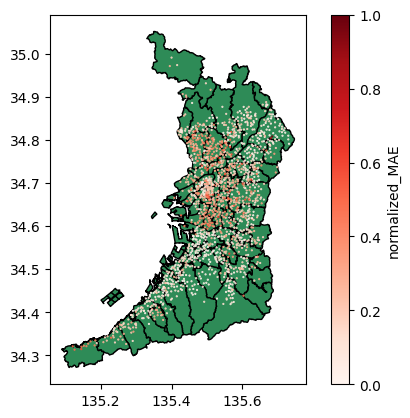

In [15]:
# プロット作成
fig, ax = plt.subplots()
osaka_map.plot(ax=ax, color='seagreen', edgecolor='black')
plt.scatter(beforeplot['fX'], beforeplot['fY'],s=0.31, c=beforeplot[0], cmap='Reds',alpha=1.0 )
plt.colorbar(label='normalized_MAE')
plt.show()

In [16]:
!pip install shap
import shap
shap.initjs()
explainer = shap.TreeExplainer(model,data=X_train)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 3.1 MB/s eta 0:00:00


[05:44:30] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [17]:
tr_x_shap_values = explainer.shap_values(X_train)

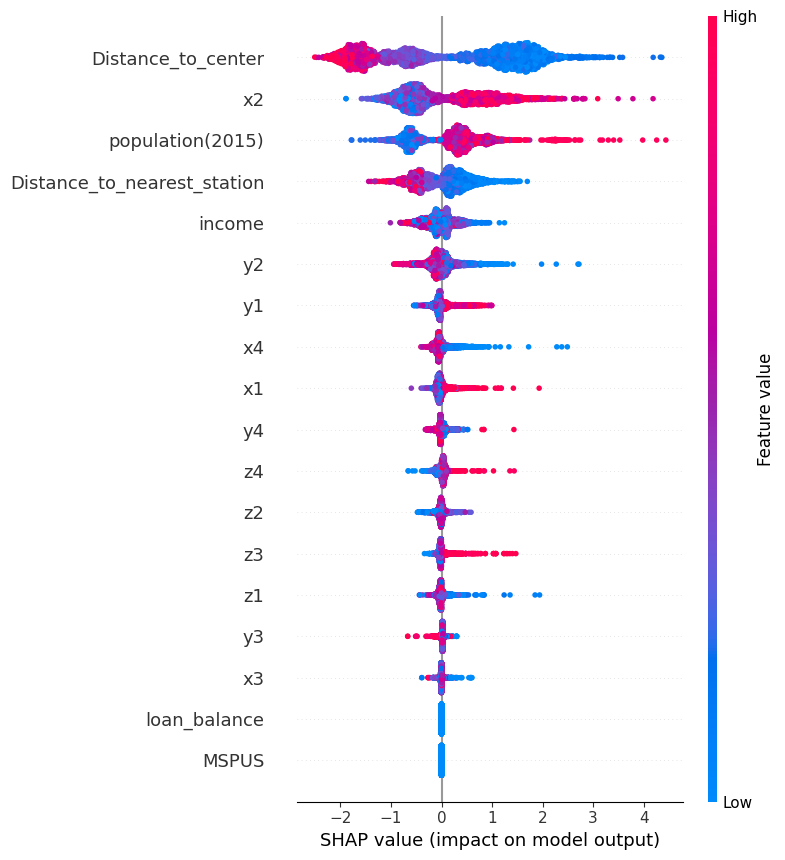

In [18]:
shap.summary_plot(shap_values=tr_x_shap_values,
                  features=X_train,
                  feature_names=X_train.columns)

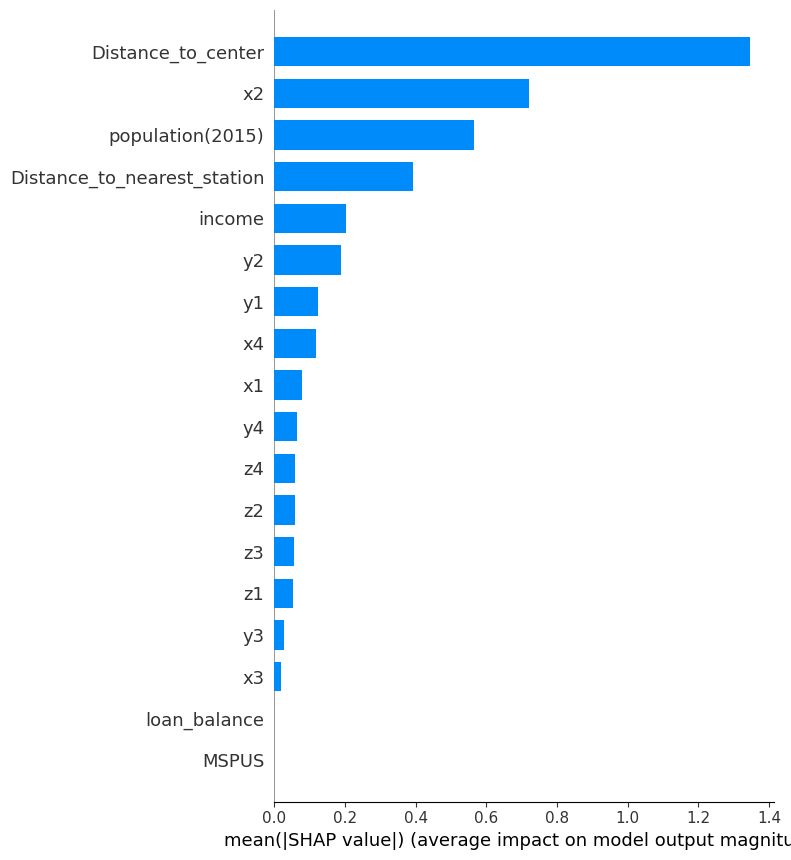

In [19]:
shap.summary_plot(shap_values=tr_x_shap_values,
                  features=X_train,
                  feature_names=X_train.columns,
                  plot_type='bar')

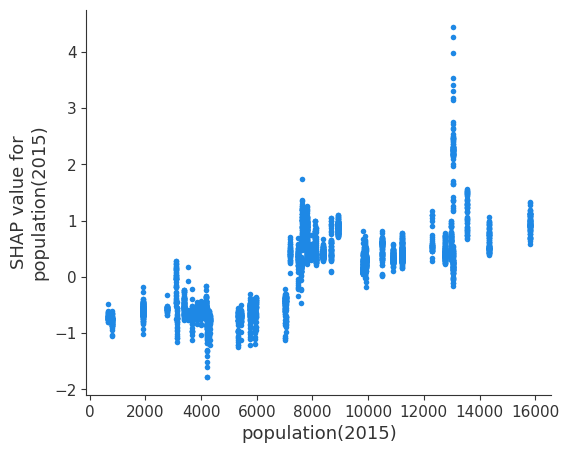

In [20]:
shap.dependence_plot(ind='population(2015)',
                     interaction_index=None,
                     shap_values=tr_x_shap_values,
                     features=X_train,
                     feature_names=X_train.columns)

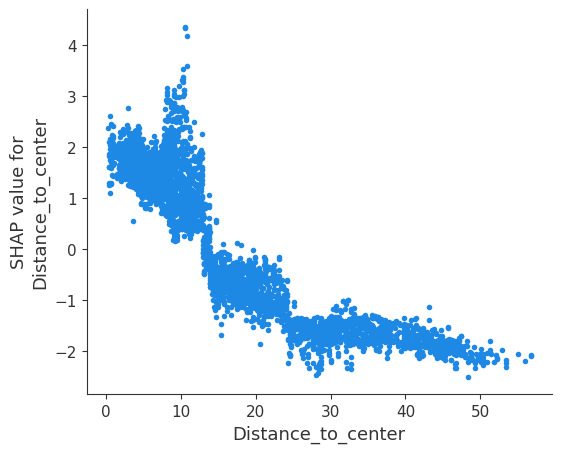

In [21]:
shap.dependence_plot(ind='Distance_to_center',
                     interaction_index=None,
                     shap_values=tr_x_shap_values,
                     features=X_train,
                     feature_names=X_train.columns)

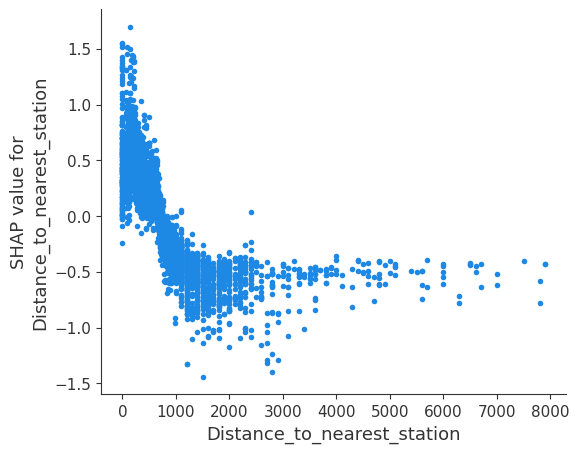

In [22]:
shap.dependence_plot(ind='Distance_to_nearest_station',
                     interaction_index=None,
                     shap_values=tr_x_shap_values,
                     features=X_train,
                     feature_names=X_train.columns)

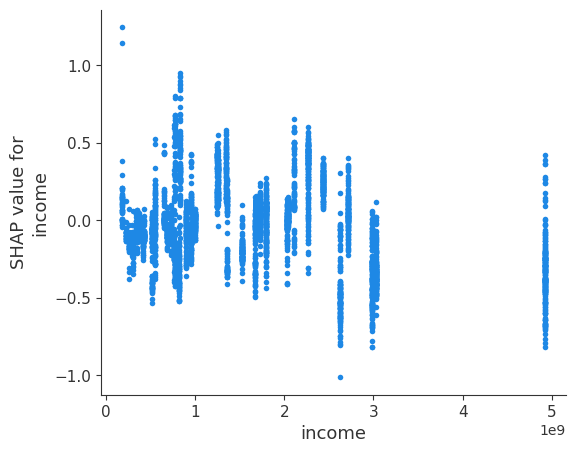

In [23]:
shap.dependence_plot(ind='income',
                     interaction_index=None,
                     shap_values=tr_x_shap_values,
                     features=X_train,
                     feature_names=X_train.columns)

In [24]:
shap.force_plot(base_value=explainer.expected_value,
                shap_values=tr_x_shap_values,
                features=X_train,
                feature_names=X_train.columns)

Output hidden; open in https://colab.research.google.com to view.

In [25]:
shap.waterfall_plot(expected_value=explainer.expected_value,
                    shap_values=tr_x_shap_values[0],
                    features=X_train.iloc[0],
                    feature_names=X_train.columns)

TypeError: waterfall() got an unexpected keyword argument 'expected_value'